# Trabalho final cálculo


### Configuracao inicial

In [1]:
# CONFIGURAÇÃO INICIAL E IMPORTAÇÕES
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

# Configuração de paths
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = current_dir

src_path = project_root / 'src'
data_path = project_root / 'data'
results_path = project_root / 'results'

data_path.mkdir(exist_ok=True)
results_path.mkdir(exist_ok=True)

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Ambiente configurado:")
print(f"  Project Root: {project_root}")
print(f"  Data Path: {data_path}")

Ambiente configurado:
  Project Root: /home/murilo_rosa/calculus-ml-regression
  Data Path: /home/murilo_rosa/calculus-ml-regression/data


### CONFIGURAÇÃO DO USUÁRIO

In [2]:
print("CONFIGURAÇÃO DO USUÁRIO")


DATA_FILENAME = "calculus_data.csv"    
TARGET_COLUMN = "aT"                   # Nome da coluna que você quer prever
FEATURE_ESCOLHIDA = "ax"               # Escolha: "time", "ax", "ay", "az"


print(f"Arquivo de dados: {DATA_FILENAME}")
print(f"Variável target: {TARGET_COLUMN}")
print(f"Feature para análise: {FEATURE_ESCOLHIDA}")

CONFIGURAÇÃO DO USUÁRIO
Arquivo de dados: calculus_data.csv
Variável target: aT
Feature para análise: ax


### CARREGAMENTO DE DADOS

In [3]:
print("CARREGAMENTO DE DADOS")

file_path = data_path / DATA_FILENAME
print(f"Procurando dados em: {file_path}")

if file_path.exists():
    df = pd.read_csv(file_path)
    print(f"Dados carregados: {df.shape[0]} linhas, {df.shape[1]} colunas")
    
    print("\nPrimeiras linhas do dataset:")
    display(df.head())
    
    print("\nInformações do dataset:")
    print(df.info())
    
    print("\nEstatísticas descritivas:")
    display(df.describe())
    
    # Mostra features disponíveis
    features_disponiveis = [col for col in df.columns if col != TARGET_COLUMN]
    print(f"\nFeatures disponíveis:")
    for i, feature in enumerate(features_disponiveis):
        print(f"  {i+1}. {feature}")
        
else:
    print("Arquivo não encontrado!")
    print("Arquivos disponíveis na pasta data/:")
    for f in data_path.glob("*.csv"):
        print(f"  - {f.name}")
    df = None

CARREGAMENTO DE DADOS
Procurando dados em: /home/murilo_rosa/calculus-ml-regression/data/calculus_data.csv
Dados carregados: 3203 linhas, 5 colunas

Primeiras linhas do dataset:


,time,ax,ay,az,aT
0,0.005,-0.0112,0.0159,0.0539,0.057
1,0.023,-0.0721,-0.0435,-0.1818,0.200
2,0.040,0.0073,-0.0086,-0.1048,0.105
3,0.059,-0.1270,0.0126,-0.1444,0.193
4,0.078,0.0337,0.0125,0.1407,0.145



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    3203 non-null   float64
 1   ax      3203 non-null   float64
 2   ay      3203 non-null   float64
 3   az      3203 non-null   float64
 4   aT      3203 non-null   float64
dtypes: float64(5)
memory usage: 125.2 KB
None

Estatísticas descritivas:


,time,ax,ay,az,aT
count,3203.000000,3203.000000,3203.000000,3203.000000,3203.000000
mean,30.413481,-0.074254,0.006717,-0.140280,0.167814
std,17.564881,0.032382,0.031293,0.064714,0.057350
min,0.005000,-0.228400,-0.121700,-0.657300,0.017000
25%,15.206000,-0.095200,-0.013750,-0.182400,0.129000
50%,30.411000,-0.075300,0.006800,-0.141500,0.165000
75%,45.613000,-0.054600,0.027800,-0.097950,0.205000
max,60.817000,0.075900,0.190500,0.161600,0.721000



Features disponíveis:
  1. time
  2. ax
  3. ay
  4. az


### MÓDULOS DE REGRESSÃO E PRÉ-PROCESSAMENTO


In [4]:
print("Carregando módulos...")

class SimplePreprocessor:
    def __init__(self):
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
    
    def prepare_data(self, df, target_column, feature_column=None):
        """Prepara dados para treinamento com feature específica"""
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        # Se feature específica foi escolhida
        if feature_column and feature_column in X.columns:
            X = X[[feature_column]]
            print(f"Usando feature específica: {feature_column}")
        # Se múltiplas features e nenhuma especificada, usa apenas a primeira
        elif X.shape[1] > 1:
            print(f"Multiplas features. Usando a primeira: {X.columns[0]}")
            X = X.iloc[:, 0:1]
        
        # Divide os dados
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        return X_train, X_test, y_train, y_test

class RegressionManager:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_linear(self, X_train, X_test, y_train, y_test):
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        metrics_train = self._calculate_metrics(y_train, y_pred_train)
        metrics_test = self._calculate_metrics(y_test, y_pred_test)
        
        self.models['Linear'] = model
        self.results['Linear'] = {
            'predictions': {'train': y_pred_train, 'test': y_pred_test},
            'metrics': {'train': metrics_train, 'test': metrics_test}
        }
        
        print(f"Linear - R²: {metrics_test['R²']:.4f}")
        return model
    
    def train_polynomial(self, X_train, X_test, y_train, y_test, degree=2):
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('linear', LinearRegression())
        ])
        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        metrics_train = self._calculate_metrics(y_train, y_pred_train)
        metrics_test = self._calculate_metrics(y_test, y_pred_test)
        
        model_name = f'Poly_{degree}'
        self.models[model_name] = model
        self.results[model_name] = {
            'predictions': {'train': y_pred_train, 'test': y_pred_test},
            'metrics': {'train': metrics_train, 'test': metrics_test}
        }
        
        print(f"Poly_{degree} - R²: {metrics_test['R²']:.4f}")
        return model
    
    def _calculate_metrics(self, y_true, y_pred):
        return {
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred)
        }
    
    def compare_models(self):
        comparison = []
        for name, result in self.results.items():
            comparison.append({
                'Modelo': name,
                'R²_Treino': result['metrics']['train']['R²'],
                'R²_Teste': result['metrics']['test']['R²'],
                'MSE_Teste': result['metrics']['test']['MSE']
            })
        return pd.DataFrame(comparison)

print("Módulos carregados!")

Carregando módulos...
Módulos carregados!


### PRÉ-PROCESSAMENTO


In [5]:
# PRÉ-PROCESSAMENTO
print("PRÉ-PROCESSAMENTO")

if df is not None:
    # Verifica se a feature escolhida existe
    if FEATURE_ESCOLHIDA not in df.columns:
        print(f"Feature {FEATURE_ESCOLHIDA} não encontrada!")
        features_disponiveis = [col for col in df.columns if col != TARGET_COLUMN]
        if features_disponiveis:
            FEATURE_ESCOLHIDA = features_disponiveis[0]
            print(f"Usando feature padrão: {FEATURE_ESCOLHIDA}")
        else:
            print("Nenhuma feature disponível!")
    
    preprocessor = SimplePreprocessor()
    X_train, X_test, y_train, y_test = preprocessor.prepare_data(
        df, TARGET_COLUMN, FEATURE_ESCOLHIDA
    )
    
    print(f"Dados de treino: {X_train.shape[0]} amostras")
    print(f"Dados de teste: {X_test.shape[0]} amostras")
    print(f"Feature usada: {X_train.columns[0]}")
else:
    print("Não foi possível fazer pré-processamento - dados não carregados")
    X_train, X_test, y_train, y_test = None, None, None, None

PRÉ-PROCESSAMENTO
Usando feature específica: ax
Dados de treino: 2562 amostras
Dados de teste: 641 amostras
Feature usada: ax


### TREINAMENTO DOS MODELOS


In [6]:
print("TREINAMENTO DOS MODELOS")

if X_train is not None:
    regressor = RegressionManager()
    
    print("\nTreinando modelos...")
    linear_model = regressor.train_linear(X_train, X_test, y_train, y_test)
    poly2_model = regressor.train_polynomial(X_train, X_test, y_train, y_test, degree=2)
    poly3_model = regressor.train_polynomial(X_train, X_test, y_train, y_test, degree=3)
    
    print("\nTodos os modelos treinados!")
else:
    print("Não foi possível treinar modelos - dados não disponíveis")
    regressor = None

TREINAMENTO DOS MODELOS

Treinando modelos...
Linear - R²: 0.1741
Poly_2 - R²: 0.1800
Poly_3 - R²: 0.1791

Todos os modelos treinados!


### COMPARAÇÃO DE MODELOS


COMPARAÇÃO DE MODELOS


,Modelo,R²_Treino,R²_Teste,MSE_Teste
0,Linear,0.186777,0.174087,0.002701
1,Poly_2,0.208855,0.180025,0.002682
2,Poly_3,0.209582,0.179066,0.002685


Melhor modelo: Poly_2
R² no conjunto de teste: 0.1800


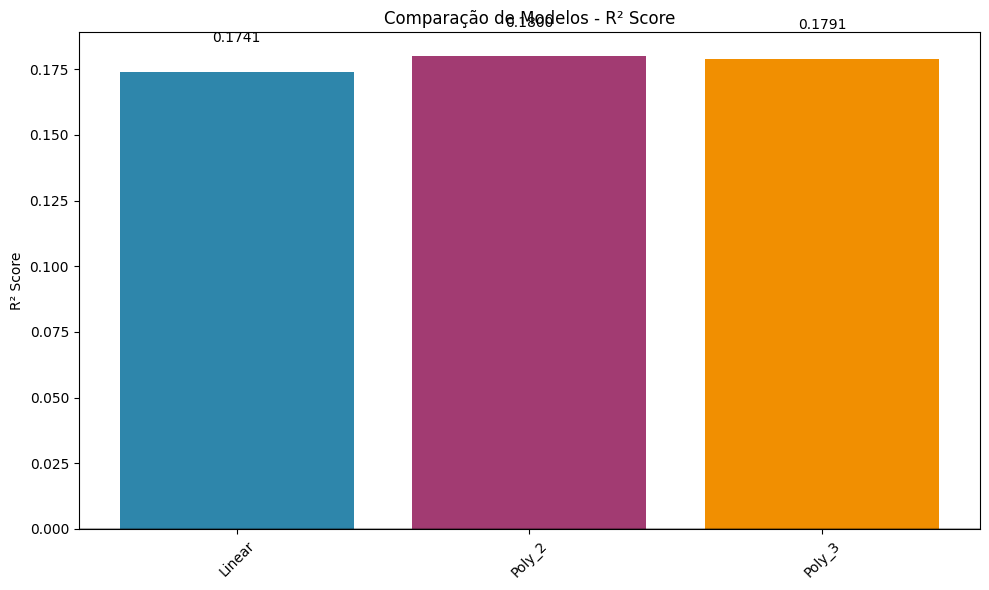

In [7]:
print("COMPARAÇÃO DE MODELOS")

if regressor and regressor.results:
    comparison_df = regressor.compare_models()
    display(comparison_df)
    
    best_model_idx = comparison_df['R²_Teste'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Modelo']
    best_r2 = comparison_df.loc[best_model_idx, 'R²_Teste']
    
    print(f"Melhor modelo: {best_model_name}")
    print(f"R² no conjunto de teste: {best_r2:.4f}")
    
    # Visualização da comparação
    plt.figure(figsize=(10, 6))
    models = comparison_df['Modelo']
    r2_scores = comparison_df['R²_Teste']
    
    bars = plt.bar(models, r2_scores, color=['#2E86AB', '#A23B72', '#F18F01'])
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Comparação de Modelos - R² Score')
    plt.ylabel('R² Score')
    plt.xticks(rotation=45)
    
    # Adiciona valores nas barras
    for bar, value in zip(bars, r2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum resultado disponível para comparação")

### VISUALIZAÇÃO DAS REGRESSÕES


VISUALIZAÇÃO DAS REGRESSÕES


/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


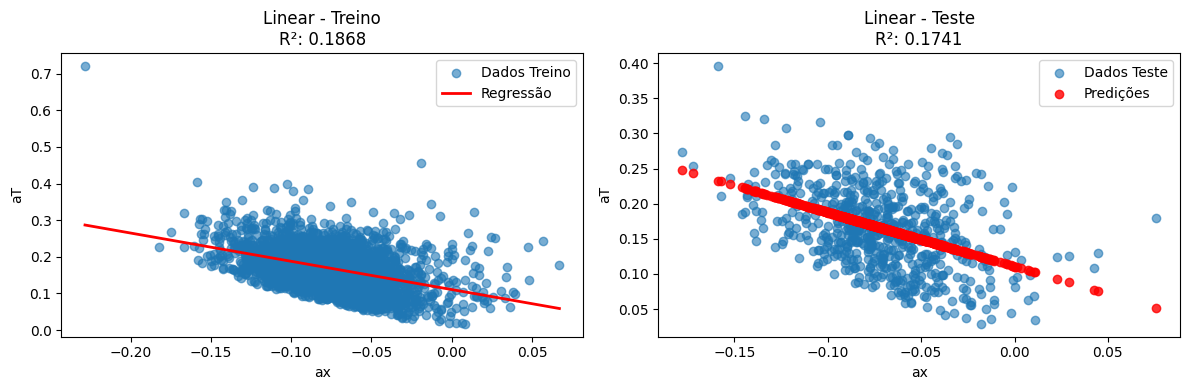

/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


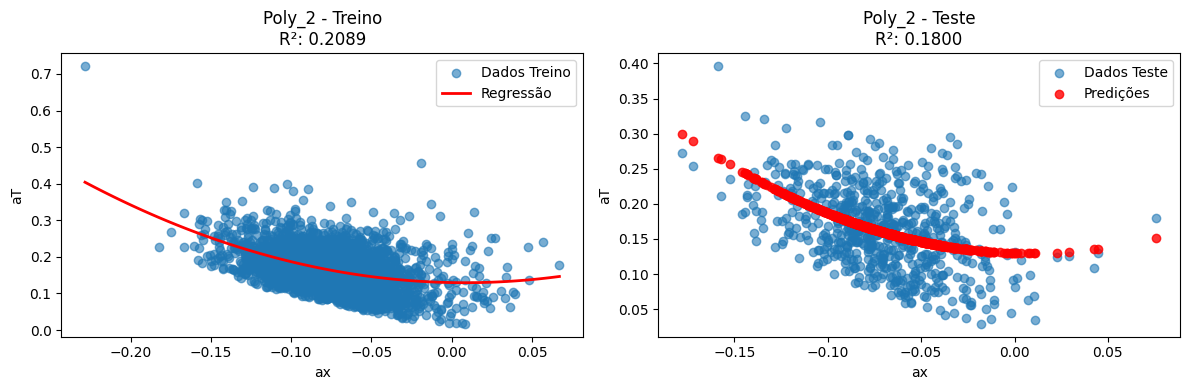

/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


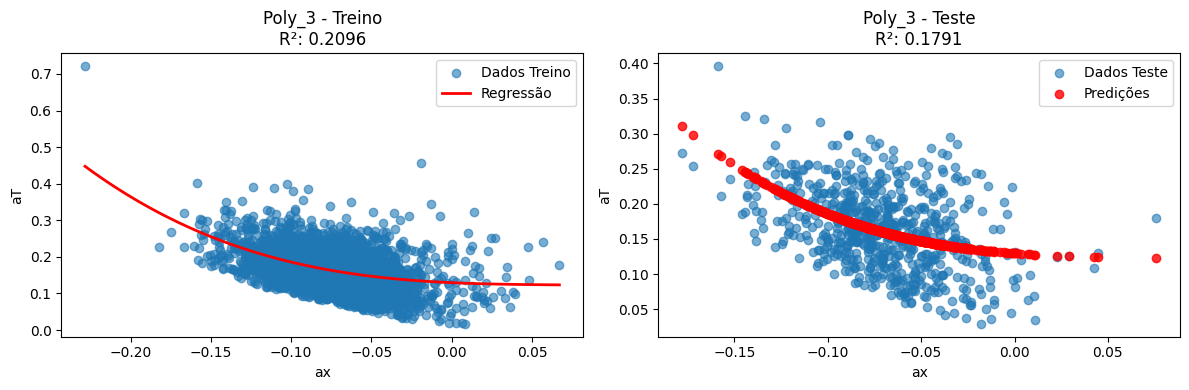

In [14]:
print("VISUALIZAÇÃO DAS REGRESSÕES")

if regressor and X_train is not None:
    feature_name = X_train.columns[0]
    
    for model_name, result in regressor.results.items():
        plt.figure(figsize=(12, 4))
        
        # Plot treino
        plt.subplot(1, 2, 1)
        plt.scatter(X_train, y_train, alpha=0.6, label='Dados Treino')
        
        # Linha da regressão
        x_line = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
        y_line = regressor.models[model_name].predict(x_line)
        plt.plot(x_line, y_line, 'r-', linewidth=2, label='Regressão')
        
        plt.title(f'{model_name} - Treino\nR²: {result["metrics"]["train"]["R²"]:.4f}')
        plt.xlabel(feature_name)
        plt.ylabel(TARGET_COLUMN)
        plt.legend()
        
        # Plot teste
        plt.subplot(1, 2, 2)
        plt.scatter(X_test, y_test, alpha=0.6, label='Dados Teste')
        plt.scatter(X_test, result['predictions']['test'], color='red', alpha=0.8, label='Predições')
        plt.title(f'{model_name} - Teste\nR²: {result["metrics"]["test"]["R²"]:.4f}')
        plt.xlabel(feature_name)
        plt.ylabel(TARGET_COLUMN)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("Não foi possível gerar visualizações")

### ANÁLISE DE CÁLCULO


ANÁLISE DE CÁLCULO DIFERENCIAL E INTEGRAL
Analisando: ax vs aT


/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/murilo_rosa/calculus-ml-regression/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1311: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/

Primeira derivada calculada
Segunda derivada calculada
Integral total: 0.0674
Área sob a curva: 0.0674
Pontos críticos encontrados: 91


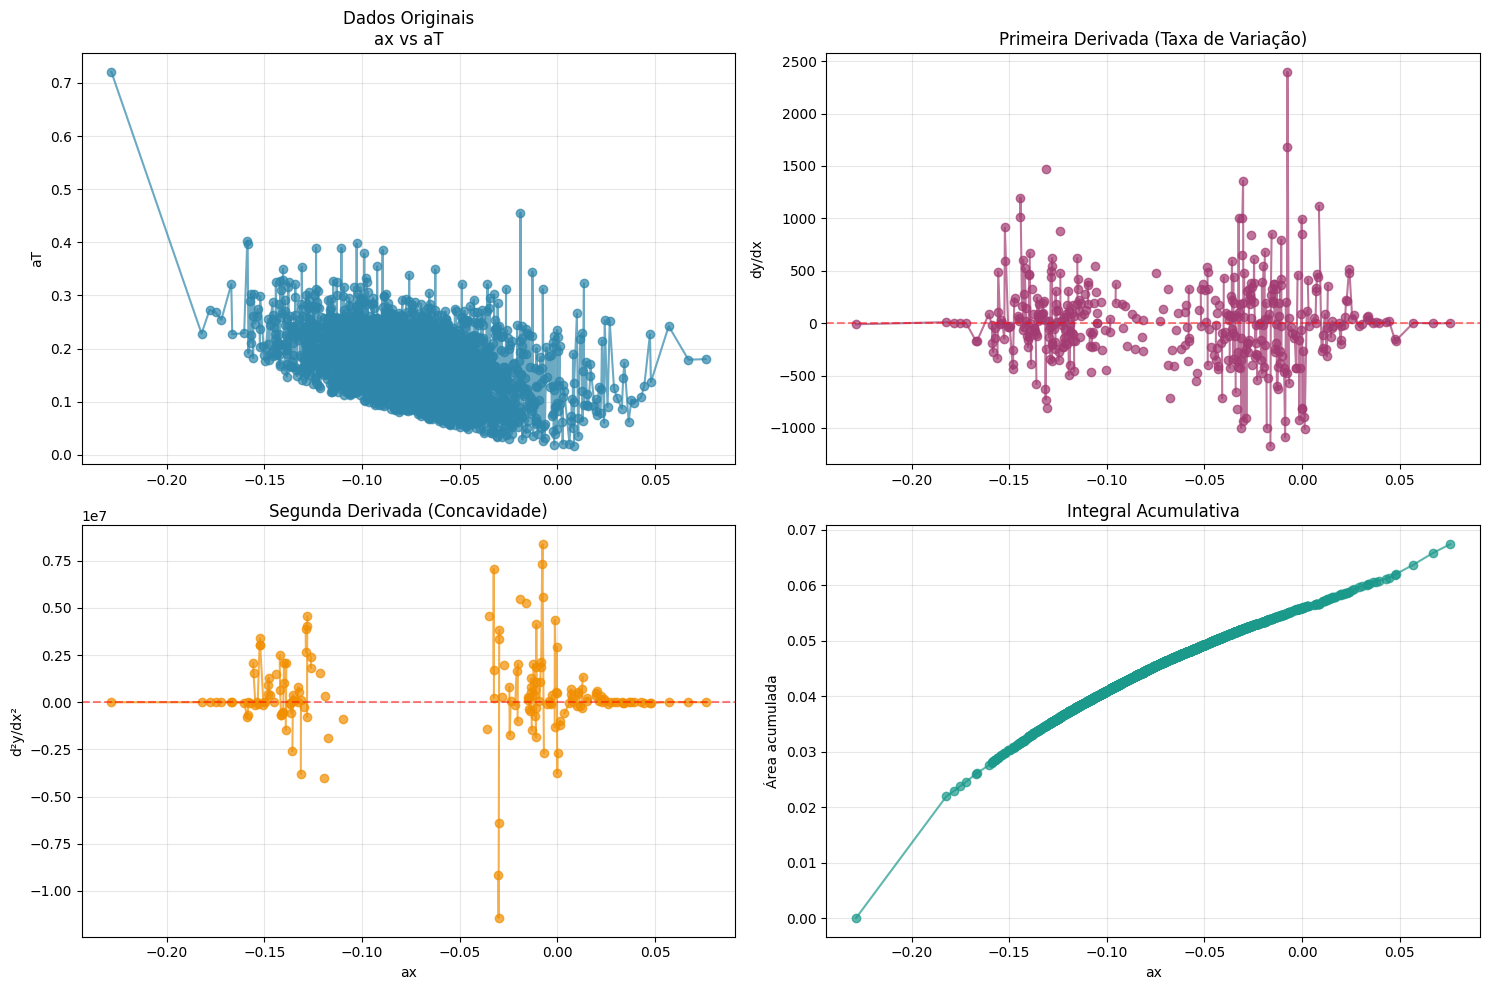


Pontos críticos encontrados:
  1. x = -0.1822, y = 0.2280, tipo = máximo
  2. x = -0.1750, y = 0.2680, tipo = máximo
  3. x = -0.1721, y = 0.2540, tipo = máximo
  4. x = -0.1670, y = 0.3210, tipo = máximo
  5. x = -0.1604, y = 0.2290, tipo = máximo


In [9]:
print("ANÁLISE DE CÁLCULO DIFERENCIAL E INTEGRAL")

class CalculusAnalysis:
    def __init__(self):
        pass
    
    def calculate_gradient(self, x, y):
        """Calcula a primeira derivada (gradiente)"""
        return np.gradient(y, x)
    
    def calculate_second_derivative(self, x, y):
        """Calcula a segunda derivada"""
        first_derivative = self.calculate_gradient(x, y)
        return np.gradient(first_derivative, x)
    
    def numerical_integral(self, x, y):
        """Calcula integral numérica usando a regra do trapézio"""
        integral_total = np.trapz(y, x)
        integral_acumulativa = [np.trapz(y[:i+1], x[:i+1]) for i in range(len(x))]
        return integral_total, integral_acumulativa
    
    def calculate_area_under_curve(self, x, y):
        """Calcula área sob a curva"""
        return np.trapz(y, x)
    
    def find_critical_points(self, x, y):
        """Encontra pontos críticos (onde a derivada é zero)"""
        primeira_derivada = self.calculate_gradient(x, y)
        segunda_derivada = self.calculate_second_derivative(x, y)
        
        pontos_criticos = []
        
        # Encontra onde a derivada muda de sinal
        for i in range(1, len(primeira_derivada)):
            if primeira_derivada[i-1] * primeira_derivada[i] <= 0:
                ponto = {
                    'x': x[i],
                    'y': y[i],
                    'type': 'máximo' if segunda_derivada[i] < 0 else 'mínimo'
                }
                pontos_criticos.append(ponto)
        
        return pontos_criticos

# Aplica análise de cálculo
if df is not None and FEATURE_ESCOLHIDA in df.columns:
    calculus = CalculusAnalysis()
    
    # Prepara dados ordenados
    analysis_df = df.sort_values(by=FEATURE_ESCOLHIDA)
    x_data = analysis_df[FEATURE_ESCOLHIDA].values
    y_data = analysis_df[TARGET_COLUMN].values
    
    print(f"Analisando: {FEATURE_ESCOLHIDA} vs {TARGET_COLUMN}")
    
    # Cálculos
    primeira_derivada = calculus.calculate_gradient(x_data, y_data)
    segunda_derivada = calculus.calculate_second_derivative(x_data, y_data)
    integral_total, integral_acumulativa = calculus.numerical_integral(x_data, y_data)
    area_total = calculus.calculate_area_under_curve(x_data, y_data)
    pontos_criticos = calculus.find_critical_points(x_data, y_data)
    
    print(f"Primeira derivada calculada")
    print(f"Segunda derivada calculada") 
    print(f"Integral total: {integral_total:.4f}")
    print(f"Área sob a curva: {area_total:.4f}")
    print(f"Pontos críticos encontrados: {len(pontos_criticos)}")
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Dados originais
    axes[0,0].plot(x_data, y_data, 'o-', color='#2E86AB', alpha=0.7)
    axes[0,0].set_title(f'Dados Originais\n{FEATURE_ESCOLHIDA} vs {TARGET_COLUMN}')
    axes[0,0].set_ylabel(TARGET_COLUMN)
    axes[0,0].grid(True, alpha=0.3)
    
    # Primeira derivada
    axes[0,1].plot(x_data, primeira_derivada, 'o-', color='#A23B72', alpha=0.7)
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Primeira Derivada (Taxa de Variação)')
    axes[0,1].set_ylabel('dy/dx')
    axes[0,1].grid(True, alpha=0.3)
    
    # Segunda derivada
    axes[1,0].plot(x_data, segunda_derivada, 'o-', color='#F18F01', alpha=0.7)
    axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1,0].set_title('Segunda Derivada (Concavidade)')
    axes[1,0].set_xlabel(FEATURE_ESCOLHIDA)
    axes[1,0].set_ylabel('d²y/dx²')
    axes[1,0].grid(True, alpha=0.3)
    
    # Integral acumulativa
    axes[1,1].plot(x_data, integral_acumulativa, 'o-', color='#1B998B', alpha=0.7)
    axes[1,1].set_title('Integral Acumulativa')
    axes[1,1].set_xlabel(FEATURE_ESCOLHIDA)
    axes[1,1].set_ylabel('Área acumulada')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostra pontos críticos
    if pontos_criticos:
        print("\nPontos críticos encontrados:")
        for i, ponto in enumerate(pontos_criticos[:5]):
            print(f"  {i+1}. x = {ponto['x']:.4f}, y = {ponto['y']:.4f}, tipo = {ponto['type']}")
else:
    print("Não foi possível realizar análise de cálculo")

### RELATÓRIO FINAL


In [10]:
# RELATÓRIO FINAL
print("="*50)
print("RELATÓRIO FINAL")
print("="*50)

if df is not None:
    print(f"\nDADOS:")
    print(f"  - Dataset: {DATA_FILENAME}")
    print(f"  - Amostras: {len(df)}")
    print(f"  - Features: {len(df.columns) - 1}")
    print(f"  - Target: {TARGET_COLUMN}")
    print(f"  - Feature analisada: {FEATURE_ESCOLHIDA}")

if 'regressor' in locals() and regressor and regressor.results:
    print(f"\nMODELOS:")
    for idx, row in comparison_df.iterrows():
        status = "BOM" if row['R²_Teste'] > 0.7 else "MODERADO" if row['R²_Teste'] > 0.4 else "BAIXO"
        print(f"  - {row['Modelo']}: R² = {row['R²_Teste']:.4f} ({status})")
    
    print(f"\nRESULTADO:")
    print(f"  - Melhor modelo: {best_model_name}")
    print(f"  - R² score: {best_r2:.4f}")
    print(f"  - Explica {best_r2*100:.1f}% da variância")

if 'area_total' in locals():
    print(f"\nANÁLISE DE CÁLCULO:")
    print(f"  - Área total sob a curva: {area_total:.4f}")
    print(f"  - Pontos críticos identificados: {len(pontos_criticos)}")

print(f"\nPRÓXIMOS PASSOS:")
print("  - Testar com diferentes features")
print("  - Coletar mais dados para melhorar accuracy")
print("  - Experimentar outros algoritmos de ML")

RELATÓRIO FINAL

DADOS:
  - Dataset: calculus_data.csv
  - Amostras: 3203
  - Features: 4
  - Target: aT
  - Feature analisada: ax

MODELOS:
  - Linear: R² = 0.1741 (BAIXO)
  - Poly_2: R² = 0.1800 (BAIXO)
  - Poly_3: R² = 0.1791 (BAIXO)

RESULTADO:
  - Melhor modelo: Poly_2
  - R² score: 0.1800
  - Explica 18.0% da variância

ANÁLISE DE CÁLCULO:
  - Área total sob a curva: 0.0674
  - Pontos críticos identificados: 91

PRÓXIMOS PASSOS:
  - Testar com diferentes features
  - Coletar mais dados para melhorar accuracy
  - Experimentar outros algoritmos de ML


### RANDOM FOREST

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

print("=== RANDOM FOREST ===")

# Usa TODAS as features (não apenas ax)
X_all = df[['time', 'ax', 'ay', 'az']]
y_all = df['aT']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Treina Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_all, y_train_all)

# Previsões
y_pred_rf = rf_model.predict(X_test_all)
r2_rf = r2_score(y_test_all, y_pred_rf)

print(f"Random Forest R²: {r2_rf:.4f}")

# Comparação
print("\n=== COMPARAÇÃO FINAL ===")
print(f"Linear Regression: 0.1741")
print(f"Polynomial (Grau 2): 0.1800") 
print(f"Random Forest: {r2_rf:.4f}")

=== RANDOM FOREST ===
Random Forest R²: 0.9949

=== COMPARAÇÃO FINAL ===
Linear Regression: 0.1741
Polynomial (Grau 2): 0.1800
Random Forest: 0.9949


### COMPARAÇÃO FINAL ENTRE MODELOS

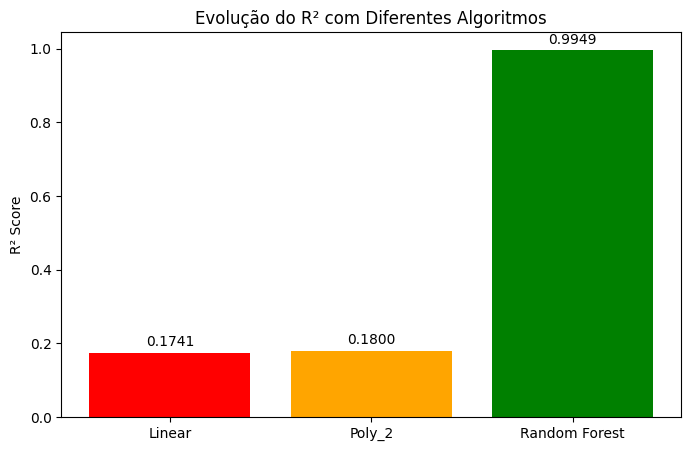

In [12]:
models = ['Linear', 'Poly_2', 'Random Forest']
r2_scores = [0.1741, 0.1800, r2_rf]  

plt.figure(figsize=(8, 5))
bars = plt.bar(models, r2_scores, color=['red', 'orange', 'green'])
plt.title('Evolução do R² com Diferentes Algoritmos')
plt.ylabel('R² Score')

for bar, value in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.4f}', ha='center', va='bottom')

plt.show()